# Data Preprocessing

In [1]:
import os
import pandas as pd
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
import torch
import torchaudio
import json

## Load CSV + JSON

In [2]:
real_path = "KAGGLE/AUDIO/REAL"
fake_path = "KAGGLE/AUDIO/FAKE"
json_path = "deep-voice-deepfake-voice-recognition-metadata.json"
csv_path = "KAGGLE/DATASET-balanced.csv"

with open(json_path, 'r') as f:
    metadata = json.load(f)

df = pd.read_csv(csv_path)
df['LABEL'] = (df['LABEL'] == 'REAL').astype(np.int8)

#DF is now our csv dataset, shape (11778, 27)

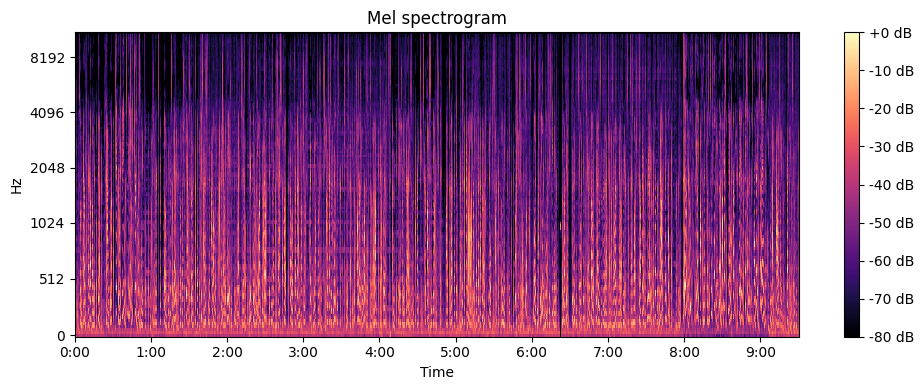

In [3]:
import librosa
import librosa.display
import matplotlib.pyplot as plt

# Function to load audio and convert to spectrogram
def audio_to_spectrogram(file_path):
    y, sr = librosa.load(file_path)
    S = librosa.feature.melspectrogram(y=y, sr=sr)
    S_DB = librosa.power_to_db(S, ref=np.max)
    return S_DB

# Example usage
file_path = os.path.join(real_path, os.listdir(real_path)[1])
spectrogram = audio_to_spectrogram(file_path)

plt.figure(figsize=(10, 4))
librosa.display.specshow(spectrogram, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel spectrogram')
plt.tight_layout()
plt.show()


# Feature Extraction

In [4]:
#audio_path will contain the path to /FAKE and /REAL
def extract_features(audio_path, max_length=500):
    features = []
    labels = []

    for folder in os.listdir(audio_path):
        path = os.path.join(audio_path, folder)

        for file in os.listdir(path):
            file_dir = os.path.join(path, file)
            try:
                # Load the audio
                audio, _ = librosa.load(file_dir, sr=16000)
                # Extract features (using Mel-Frequency Cepstral Coefficients)
                # we are setting the 
                mfccs = librosa.feature.mfcc(y=audio, sr=16000, n_mfcc=40)
                # If the audio is too short, we pad it.
                if mfccs.shape[1] < max_length:
                    mfccs = np.pad(mfccs, ((0, 0), (0, max_length - mfccs.shape[1])), mode='constant')
                    print("Short")
                else:
                    mfccs = mfccs[:, :max_length]
                features.append(mfccs)
                
                # Assign label
                if folder == 'FAKE':
                    labels.append(1)  # 1 for fake
                else:
                    labels.append(0)  # 0 for real              
            except Exception as e:
                print(f"Error encountered while parsing file: {file_path}, Exception: {e}")
                continue

    return np.array(features), np.array(labels)

In [5]:
folder_path = "KAGGLE/AUDIO"
x, y = extract_features(folder_path)
# (x, 40, 500)
# 40 number of features, we set n_mfcc=40. Each frame of audio signal is represented by 40 mfccs
# 500 is the length of each featue sequence as we set MAX_LENGTH

# (y,)
# y contains the label per x datapoint, 1 for fake, 0 for real

# Build Transformer Dataset

In [6]:
from torch.utils.data import DataLoader, Dataset

class AudioDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels

    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, idx):
        #return feature and label at given idx
        return torch.tensor(self.features[idx], dtype=torch.float32), torch.tensor(self.labels[idx], dtype=torch.long)
    
train_dataset = AudioDataset(x, y)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Build Transformer Model

In [7]:
import torch.nn as nn
import torch.optim as optim

class TransformerModel(nn.Module):
    def __init__(self, input_dim, nhead, num_encoder_layers, num_classes):
        super(TransformerModel, self).__init__()
        self.transformer_encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=input_dim, nhead=nhead),
            num_layers=num_encoder_layers
        )
        self.fc = nn.Linear(input_dim, num_classes)

    def forward(self, x):
        # Assuming x is of shape (seq_len, batch, features)
        x = self.transformer_encoder(x)  # Only pass to encoder
        x = self.fc(x.mean(dim=0))  # Aggregate over sequence and pass to a fully connected layer
        return x


# Define model parameters
input_dim = 500  # Number of Mel bands
nhead = 4
num_encoder_layers = 4
num_classes = 2

# Initialize model, loss function, and optimizer
model = TransformerModel(input_dim, nhead, num_encoder_layers, num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)   

c:\Users\Kai\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [8]:
# Training loop
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs = inputs.permute(1, 0, 2)  # Change to (seq_len, batch, features)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(1)  # Adjust for batch dimension being second
    epoch_loss = running_loss / len(train_loader.dataset)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")


Epoch 1/10, Loss: 0.8803
Epoch 2/10, Loss: 0.6981
Epoch 3/10, Loss: 2.2460
Epoch 4/10, Loss: 0.9084
Epoch 5/10, Loss: 0.8252
Epoch 6/10, Loss: 0.6247
Epoch 7/10, Loss: 0.4343
Epoch 8/10, Loss: 0.4326
Epoch 9/10, Loss: 0.4007
Epoch 10/10, Loss: 0.4263


In [9]:
# Split the dataset into training and test sets
from sklearn.model_selection import train_test_split

train_features, test_features, train_labels, test_labels = train_test_split(x, y, test_size=0.2, random_state=42)
train_dataset = AudioDataset(train_features, train_labels)
test_dataset = AudioDataset(test_features, test_labels)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Switch the model to evaluation mode
model.eval()
test_loss = 0.0
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.permute(1, 0, 2)  # Change to (seq_len, batch, features) to match Transformer input
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item() * inputs.size(1)  # Adjust for batch dimension being second
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_loss = test_loss / len(test_loader.dataset)
accuracy = 100 * correct / total
print(f"Test Loss: {test_loss:.4f}, Accuracy: {accuracy:.2f}%")



Test Loss: 0.7210, Accuracy: 76.92%


In [10]:
model

TransformerModel(
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-3): 4 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=500, out_features=500, bias=True)
        )
        (linear1): Linear(in_features=500, out_features=2048, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=2048, out_features=500, bias=True)
        (norm1): LayerNorm((500,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((500,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (fc): Linear(in_features=500, out_features=2, bias=True)
)